Contributors: PANTELEIMON SFAKIANAKIS and ALEXANDROS SKONDRAS<br> in the context of Deep Learning of MSc Data Science, AUEB.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, precision_recall_curve, auc, f1_score
import keras_tuner as kt
from keras.layers import LeakyReLU, ELU,BatchNormalization
import warnings
warnings.filterwarnings("ignore")
from keras import models
import pickle
from keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
np.random.seed(5) # Define the seed for numpy.
set_seed(7) # Define the seed for Tensorflow.

Loading the data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, int_train_labels), (test_images, int_test_labels) = fashion_mnist.load_data()
#https://www.tensorflow.org/tutorials/keras/classification

4431872/4422102 [==============================] - 0s 0us/step


####Exploratory analysis

In [ ]:
print(int_train_labels.shape)
print(train_images.shape)
print(test_images.shape)
print(int_test_labels.shape)

(60000,)
(60000, 28, 28)
(10000, 28, 28)
(10000,)


In [ ]:
train_labels = [ str(x) for x in int_train_labels ]
test_labels = [str(x) for x in int_test_labels]

In [ ]:
# replace label values with their actual name
label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

for i in range(len(label_names)):
  train_labels = np.where(train_labels == '0', label_names[0], train_labels)
  test_labels = np.where(test_labels == '0', label_names[0], test_labels)
  train_labels = np.where(train_labels == str(i), label_names[i], train_labels)
  test_labels = np.where(test_labels == str(i), label_names[i], test_labels)

We are indicatively going to print some images of the training set.

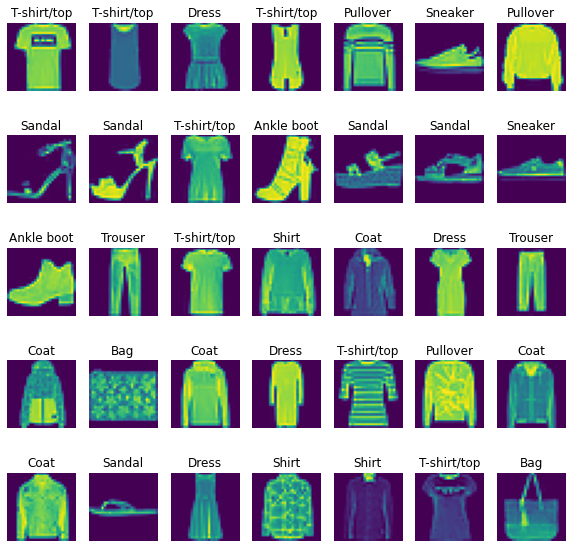

In [ ]:
fig = plt.figure(figsize=(10, 10))
columns = 7
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_images[i])
    plt.axis('off')
    plt.title(train_labels[i])
plt.show()

Train - Validation<br>
Cross Validation will not be used because the number of data suffices.<br>



In [ ]:
x_train, x_val, train_y, val_y = train_test_split(train_images,train_labels , test_size=0.1, random_state=15)

Now, we will check the class balance of the data.

In [ ]:
# Count the instances of each item in train and validation sets and sort the dictionaries by name
count_dict = Counter(train_y)
count_dict_val = Counter(val_y)
count_dict_test = Counter(test_labels)

count_dict = dict(sorted(count_dict.items(), key=lambda item: item[0]))
count_dict_val = dict(sorted(count_dict_val.items(), key=lambda item: item[0]))
count_dict_test = dict(sorted(count_dict_test.items(), key=lambda item: item[0]))

In [ ]:
# Creating dataframes of the item counts
train_df = pd.DataFrame.from_dict(dict(count_dict), orient='index')
val_df = pd.DataFrame.from_dict(dict(count_dict_val), orient='index')

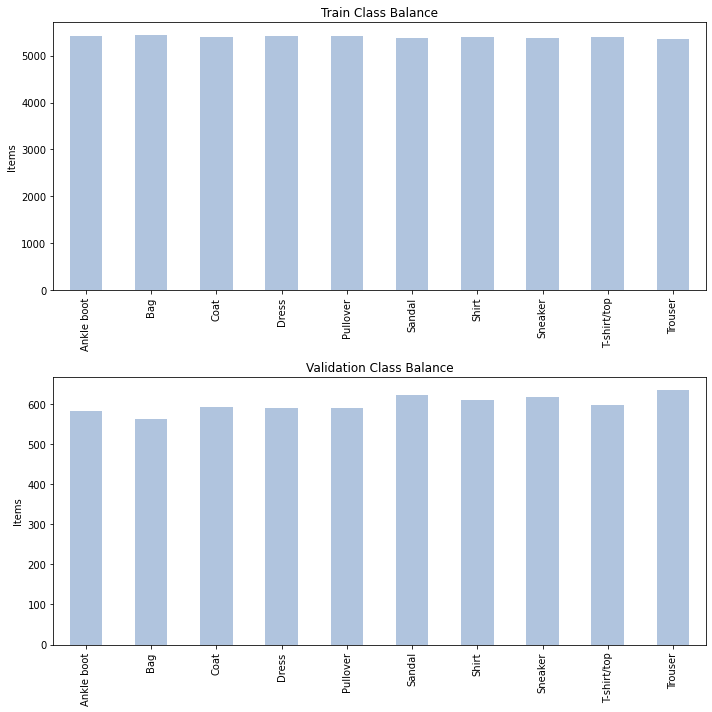

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
_ = train_df.plot(kind="bar", ylabel="Items", ax=axs[0],legend=False,title = "Train Class Balance",color="lightsteelblue")
_ = val_df.plot(kind="bar", ylabel="Items", ax=axs[1],legend=False,title = "Validation Class Balance",color="lightsteelblue")
fig.tight_layout()

It is apparent that the class balance is well preserved.

In [ ]:
x_train, x_val, train_y, val_labels = train_test_split(train_images,int_train_labels , test_size=0.1, random_state=15)

In [ ]:
print(x_train.shape)
print(train_y.shape)
print(x_val.shape)
print(val_labels.shape)

(54000, 28, 28)
(54000,)
(6000, 28, 28)
(6000,)


#####MLP preprocessing

For the preprocessing of our data before the MLP model, each image is flattened. The images are reshaped from matrices with dimmension 28x28, into arrays with 784 elements. Neural networks use small weight values to process inputs. As a result inputs with large integer values, might disrupt or slow down the learning process. In order to prevent this from happening the data are normalized. By dividing the pixel values with 255, they are scaled between 0 and 1. The labels are also transformed into one hot vectors in order to feed them into the MLP.

In [ ]:
classes = 10
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1]**2)
X_val = x_val.reshape(x_val.shape[0],x_val.shape[1]**2)
X_test = test_images.reshape(test_images.shape[0],test_images.shape[1]**2)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255
Y_train = to_categorical(train_y, classes)
Y_val = to_categorical(val_labels, classes)
Y_test = to_categorical(int_test_labels, classes)

Cleaning up the unnecessarily saved parameters.

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

###MLP tuning and training with Functional API

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=2),
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, restore_best_weights=True)]
                                                                          # If False, the model weights obtained at the last step of training are used.
                                                                          # else, restores weights from the best epoch in that set.

In [ ]:
def build_model(hp):

  input = Input(shape=(784,), name='Input')
  x = input

  # Define the remaining hidden layers.
  for i in range(hp.Int('MLP_layers', 1, 3)):
    hidden_activ = hp.Choice("hidden_activ", ["LeakyReLU", "ELU"])
    if hidden_activ == "LeakyReLU":
      with hp.conditional_scope("hidden_activ", ["LeakyReLU"]):
        x = Dense(
            units = hp.Choice('units_'+str(i), [64, 128, 256]),
            kernel_initializer = hp.Choice('hidden_initializer'+str(i), ['glorot_uniform']),
            activation = LeakyReLU(hp.Float('leaky_alpha_'+str(i), 0, 0.4)),
                                  # includes PRelu, relu and LeakyRelu cases
            name='hidden_layer_'+str(i))(x)
    
    else:
      with hp.conditional_scope("hidden_activ", ["ELU"]):
        x = Dense(
            units = hp.Choice('units_'+str(i), [64, 128, 256]),
            kernel_initializer = hp.Choice('hidden_initializer_'+str(i), ['glorot_uniform']),
            activation = ELU(hp.Float('elu_alpha_'+str(i), 0.1, 0.3)),
            name='hidden_layer_'+str(i))(x)
        
    x = Dropout(hp.Float('rate'+str(i), 0, 0.4))(x)

  # Define the output layer.
  output = Dense(
      units = classes,   # 10
      kernel_initializer = hp.Choice('output_initializer', ['glorot_uniform']),
      activation = 'softmax',
      name = 'output')(x)

  # Define the model and train it.
  model = Model(inputs = input, outputs = output)
  model.compile(optimizer = Adam(learning_rate=hp.Float("Adam_lr",0.001,0.01)),  # SGD generalizes better than Adam, but Adam is faster
                                      loss='categorical_crossentropy', metrics=['accuracy'])
  
  # hp.Choice[Adam(lr=hp.Float("Adam_lr",0.001,0.01)), SGD(lr=hp.Float("SGD_lr",0.001,0.01))] does NOT work

  return model


In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss', seed = 11, overwrite = True, max_trials = 15)

In [ ]:
tuner.search(X_train, Y_train, epochs = 40, callbacks = callbacks, validation_data = (X_val, Y_val))

Trial 15 Complete [00h 01m 33s]
val_loss: 0.27281516790390015

Best val_loss So Far: 0.2642446458339691
Total elapsed time: 00h 32m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
MLP_layers: 1
hidden_activ: LeakyReLU
units_0: 256
hidden_initializer0: glorot_uniform
leaky_alpha_0: 0.0
rate0: 0.0
output_initializer: glorot_uniform
Adam_lr: 0.001
rate1: 0.4
Score: 0.2642446458339691


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 hidden_layer_0 (Dense)      (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_model.evaluate(X_train, Y_train)

1688/1688 [==============================] - 4s 2ms/step - loss: 0.1599 - accuracy: 0.9425


[0.1598587930202484, 0.9424999952316284]

In [ ]:
best_model.evaluate(X_val, Y_val)

188/188 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.9060


[0.2642446458339691, 0.906000018119812]

In [ ]:
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3101 - accuracy: 0.8964


[0.3100917339324951, 0.896399974822998]

Retrieving the best hyperparameters.

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)

In [ ]:
final_model = build_model(best_hps[0])

Retraining the best model of the tuner to plot the learning curves.

In [ ]:
history_model = final_model.fit(X_train, Y_train, epochs=100, callbacks=callbacks, validation_data=((X_val, Y_val)))

Epoch 1/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4917 - accuracy: 0.8262 - val_loss: 0.4040 - val_accuracy: 0.8533 - lr: 1.0000e-03
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3723 - accuracy: 0.8656 - val_loss: 0.3597 - val_accuracy: 0.8687 - lr: 1.0000e-03
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3302 - accuracy: 0.8787 - val_loss: 0.3433 - val_accuracy: 0.8757 - lr: 1.0000e-03
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3085 - accuracy: 0.8869 - val_loss: 0.3473 - val_accuracy: 0.8730 - lr: 1.0000e-03
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2889 - accuracy: 0.8933 - val_loss: 0.3016 - val_accuracy: 0.8860 - lr: 1.0000e-03
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2734 - accuracy: 0.8987 - val_loss: 0.3356 - val_accuracy: 0.8823 - lr: 1.0000e-03
Epoch 7/100
1688/1688 [=====

In [ ]:
from keras import models
from keras.models import load_model
import os
os.getcwd()
os.chdir('/content/drive/MyDrive')

In [ ]:
#!mkdir -p saved_model
#final_model.save('saved_model/final_MLP_model')

In [ ]:
final_model = load_model('saved_model/final_MLP_model')

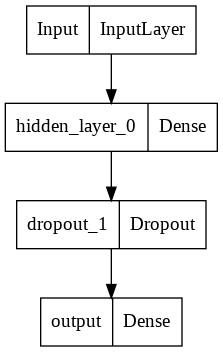

In [ ]:
tf.keras.utils.plot_model(final_model)

In [ ]:
# with open('fitted_MLP_history_dict.pkl', 'wb') as file_pi:
#      pickle.dump(history_model.history, file_pi)

In [ ]:
history_model = pickle.load(open('fitted_MLP_history_dict.pkl','rb')) # this is history_model.history

In [ ]:
history_model

{'accuracy': [0.8262222409248352,
  0.8655555844306946,
  0.8787037134170532,
  0.8869444727897644,
  0.8933333158493042,
  0.8987407684326172,
  0.9021666646003723,
  0.9215925931930542,
  0.9247037172317505,
  0.9263148307800293,
  0.9270185232162476,
  0.9290000200271606,
  0.9304259419441223,
  0.9328888654708862,
  0.9336851835250854,
  0.9339629411697388,
  0.9343518614768982,
  0.9341481328010559,
  0.9344444274902344],
 'loss': [0.4916723370552063,
  0.3722829818725586,
  0.3302459716796875,
  0.30846068263053894,
  0.28886017203330994,
  0.2734225392341614,
  0.26143860816955566,
  0.21198134124279022,
  0.20285552740097046,
  0.19948835670948029,
  0.19542963802814484,
  0.1924397200345993,
  0.18951772153377533,
  0.1829833984375,
  0.1817908138036728,
  0.18126553297042847,
  0.18038871884346008,
  0.18031281232833862,
  0.1802617907524109],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  1e-

####Architecture used for the training of the MLP model
For the selection of the architecture, BayesianOptimization was employed. Bayesian optimization doesn't demand high number of trials.<br>
For the layers used, the option of 1-3 hidden layers was given.<br>
We also choose between LeakyReLu and ELU and tune their alphas.<br>
We give the possibility of dropouts for the layers.<br>
During the compiling, Adam is chosen as the optimizer and his learning rate is 
tuned.<br>
For the sake of saving time not all hyperpameters had options for the tuning<br>
Loss is set to categorical crossentropy and metrics to be also monitored is accuracy.

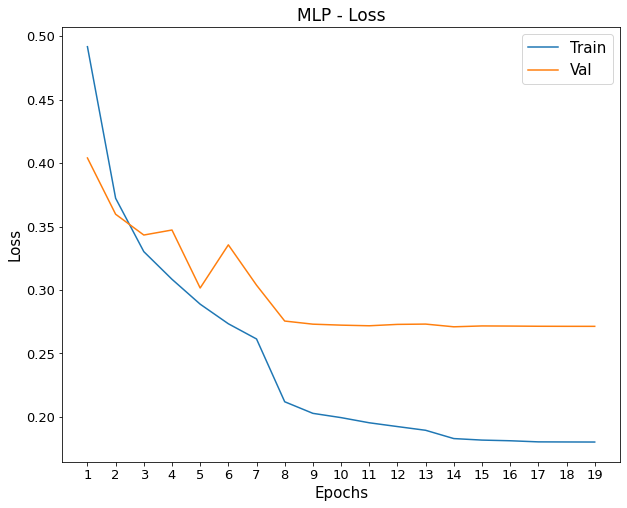

In [ ]:
# Learning Curves Loss-Epochs
plt.figure(figsize=(10,8))
epochs = np.arange(1,len(history_model['loss'])+1) # history_model.history
plt.plot(epochs,history_model['loss'])
plt.plot(epochs,history_model['val_loss'])
plt.title('MLP - Loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train', 'Val'], fontsize = 15)
plt.xticks(epochs,fontsize=13)
plt.yticks(fontsize=13)
plt.show()

It is obvious that the loss of the validation set seems like it does not decline significantly since after epoch 8, but there is still a slight decline which does not activate Early Stopping till epoch 19. However, the training loss keeps decreasing noticeably even after epoch 8.

In [ ]:
def report(x, y, set_type, model):

  probs_predictions = model.predict(x)

  y_preds = np.zeros((probs_predictions.shape[0], 1))

  for i in range(probs_predictions.shape[0]):
    max_index = np.argmax(probs_predictions[i], axis=0)
    y_preds[i] = max_index

  print(f"\nPrecision, recall, F1 scores for each class({set_type} set)")
  print(classification_report(y, y_preds,
                              target_names = np.array(["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"])))

In [ ]:
report(X_train, train_y, "train", final_model)


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.91      0.90      5402
     Trouser       1.00      0.99      0.99      5364
    Pullover       0.88      0.86      0.87      5410
       Dress       0.94      0.94      0.94      5410
        Coat       0.85      0.88      0.87      5408
      Sandal       1.00      1.00      1.00      5378
       Shirt       0.82      0.79      0.81      5389
     Sneaker       0.98      0.98      0.98      5383
         Bag       1.00      0.99      1.00      5438
  Ankle boot       0.98      0.98      0.98      5418

    accuracy                           0.93     54000
   macro avg       0.93      0.93      0.93     54000
weighted avg       0.93      0.93      0.93     54000



In [ ]:
report(X_val, val_labels, "val", final_model)


Precision, recall, F1 scores for each class(val set)
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.86       598
     Trouser       0.99      0.99      0.99       636
    Pullover       0.85      0.82      0.83       590
       Dress       0.88      0.91      0.90       590
        Coat       0.80      0.85      0.82       592
      Sandal       0.98      0.97      0.97       622
       Shirt       0.79      0.75      0.77       611
     Sneaker       0.96      0.95      0.95       617
         Bag       0.98      0.97      0.97       562
  Ankle boot       0.95      0.96      0.96       582

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



In [ ]:
report(X_test, int_test_labels, "test", final_model)


Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.81      0.81      0.81      1000
       Dress       0.88      0.91      0.90      1000
        Coat       0.80      0.82      0.81      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.74      0.71      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
final_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3074 - accuracy: 0.8949


[0.3073737621307373, 0.8949000239372253]

The loss and accuracy of the MLP are 0.3074 and 89.49% respectively. The rest of the metrics-statistics can be seen above.

In [ ]:
def conf_mat(true_set, test_set, model, labels, title):
  probs_predictions = model.predict(test_set)

  y_preds = np.zeros((probs_predictions.shape[0], 1))

  for i in range(probs_predictions.shape[0]):
    max_index = np.argmax(probs_predictions[i], axis=0)
    y_preds[i] = max_index

  cm = confusion_matrix(true_set, y_preds)
  plt.figure(figsize=((11,8.5)))
  ax = sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=label_names, yticklabels=label_names)

  ax.set_title('Fashion-Mnist Confusion Matrix - {}\n\n'.format(title), size=15.5)
  ax.set_xlabel('\nPredicted Values', size=13.5)
  ax.set_ylabel('Actual Values ', size=13.5)
  sns.set(font_scale=1)
  ax.set_xticklabels(label_names, size = 12, rotation=45)
  ax.set_yticklabels(label_names, size = 12)

  # Display the visualization of the Confusion Matrix.
  plt.show()

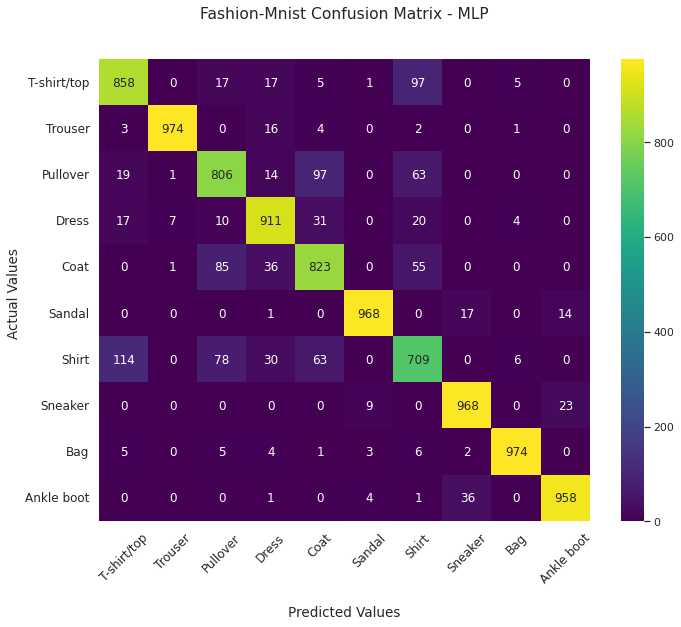

In [ ]:
conf_mat(int_test_labels, X_test, final_model, label_names, 'MLP')

As indicated in the confusion matrix and the metrics of the classification report, the classes with the most misclassifed instances are T-shirt/top, Pullover, Coat and Shirt. Shirt is distinctively the hardest class to predict correctly.

In [ ]:
clean_up(model=final_model)

### CNN

####CNN preprocessing

In [ ]:
batch_size = 128
classes = 10
epochs = 10

cnn_X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
cnn_X_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
cnn_X_test = test_images.reshape(test_images.shape[0], 28, 28, 1)

input_shape = (28, 28, 1)

cnn_X_train = cnn_X_train.astype('float32')
cnn_X_val = cnn_X_val.astype('float32')
cnn_X_test = cnn_X_test.astype('float32')

cnn_X_train /= 255
cnn_X_val /= 255
cnn_X_test /= 255

cnn_Y_train = to_categorical(train_y, classes)
cnn_Y_val = to_categorical(val_labels, classes)
cnn_Y_test = to_categorical(int_test_labels, classes)

In [ ]:
def build_a_model(hp):

  input = Input(shape = input_shape, name='cnn_Input')
  x = input

# Define the convolutional layers.
  for i in range(hp.Int('CNN_layers', 1, 4)):
    hidden_activ = hp.Choice("hidden_activ", ["LeakyReLU", "ELU"])
    if hidden_activ == "LeakyReLU":
      with hp.conditional_scope("hidden_activ", ["LeakyReLU"]):
        x = Conv2D(                                                       # data_format = channels_last (default)
            filters=hp.Choice('conv_filter_'+str(i), [8,16,32,64,128]),
                                                                          # it is common for a CNN to learn  from 32 to 512 filters

            kernel_size=hp.Choice('conv_kernel_'+str(i), values = [3,5]),
            strides=hp.Choice('strides_'+str(i), values = [1]),  # this is unnecessary because it is usually used to make it quicker, in case of too much data
            padding='same',
            dilation_rate=hp.Choice('dil_rate_'+str(i), values=[1]),
            # could change the rate using for example: values = [1,2]
            # https://github.com/transcranial/keras-js/issues/79

            activation=LeakyReLU(hp.Float('cnn_leaky_'+str(i), 0, 0.4)),
            name='cnn_hidden_layer_'+str(i))(x)
    else:
      with hp.conditional_scope("hidden_activ", ["ELU"]):
        x = Conv2D(
            filters= hp.Choice('conv_filter_'+str(i), [8,16,32,64,128]),
            kernel_size=hp.Choice('conv_kernel_'+str(i), values = [3,5]),
            strides=hp.Choice('strides_'+str(i), values = [1]),
            padding='same',
            dilation_rate=hp.Choice('dil_rate_'+str(i), values = [1]),
            activation=ELU(hp.Float('cnn_elu_'+str(i), 0, 0.4)),
            name='cnn_hidden_layer_'+str(i))(x)

    if hp.Boolean("batch_norm_"+str(i)):  
      x=BatchNormalization()(x)
    # Makes every activation zero-mean and unit-variance per batch

    x = MaxPool2D(
            pool_size=hp.Choice('pool_size_'+str(i), values = [2]),
            strides=hp.Choice('max_strides'+str(i), values = [2]),
            padding='same',
            name='MaxPool'+str(i))(x)
    
    
    x = Dropout(hp.Float('cnn_drop_rate_'+str(i), 0, 0.4))(x)

  x = Flatten(name='Flatten')(x)
  
  # Define the output layer.
  output = Dense(
      units = classes,   # 10
      kernel_initializer = hp.Choice('cnn_output_init', ['glorot_uniform']),
      activation = 'softmax',
      name = 'cnn_output')(x)

  # Define the model and train it.
  model = Model(inputs = input, outputs = output)
  model.compile(optimizer = Adam(lr=hp.Float("cnn_Adam_lr",0.001,0.01)),
                loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
tuner2 = kt.BayesianOptimization(
    build_a_model,
    objective='val_loss', seed = 11, overwrite = True, max_trials = 15)

In [ ]:
tuner2.search(cnn_X_train, cnn_Y_train, epochs = 40, callbacks = callbacks, validation_data = (cnn_X_val, cnn_Y_val), batch_size = 64)

In [ ]:
tuner2.results_summary(1)

In [ ]:
best_model_CNN = tuner2.get_best_models()[0]

In [ ]:
best_model_CNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_Input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 cnn_hidden_layer_0 (Conv2D)  (None, 28, 28, 128)      3328      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 MaxPool0 (MaxPooling2D)     (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 Flatten (Flatten)           (None, 25088)             0         
                                                             

In [ ]:
best_model_CNN.evaluate(cnn_X_train, cnn_Y_train)

1688/1688 [==============================] - 6s 4ms/step - loss: 0.1756 - accuracy: 0.9403


[0.17555125057697296, 0.9402962923049927]

In [ ]:
best_model_CNN.evaluate(cnn_X_val, cnn_Y_val)

188/188 [==============================] - 1s 3ms/step - loss: 0.2554 - accuracy: 0.9085


[0.25536543130874634, 0.9085000157356262]

In [ ]:
best_model_CNN.evaluate(cnn_X_test, cnn_Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2636 - accuracy: 0.9077


[0.2635577917098999, 0.9077000021934509]

Retrieving the best hyperparameters.

In [ ]:
best_hps_CNN = tuner2.get_best_hyperparameters(1)

In [ ]:
final_CNN_model = build_a_model(best_hps_CNN[0])

Retraining the best model of the tuner to plot the learning curves.

In [ ]:
history_model_CNN = final_CNN_model.fit(cnn_X_train, cnn_Y_train, epochs=100, callbacks=callbacks, validation_data=((cnn_X_val, cnn_Y_val)))

Epoch 1/100
1688/1688 [==============================] - 8s 5ms/step - loss: 2.6081 - accuracy: 0.8099 - val_loss: 0.4526 - val_accuracy: 0.8452 - lr: 0.0100
Epoch 2/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4769 - accuracy: 0.8434 - val_loss: 0.4287 - val_accuracy: 0.8635 - lr: 0.0100
Epoch 3/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.5901 - accuracy: 0.8331 - val_loss: 0.6152 - val_accuracy: 0.8345 - lr: 0.0100
Epoch 4/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.7645 - accuracy: 0.8263 - val_loss: 0.6746 - val_accuracy: 0.8503 - lr: 0.0100
Epoch 5/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3437 - accuracy: 0.8822 - val_loss: 0.3164 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 6/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3146 - accuracy: 0.8904 - val_loss: 0.3036 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 7/100
1688/1688 [=============================

In [ ]:
# final_CNN_model.save('saved_model/final_model_CNN')

INFO:tensorflow:Assets written to: saved_model/final_model_CNN/assets


INFO:tensorflow:Assets written to: saved_model/final_model_CNN/assets


In [ ]:
final_CNN_model = load_model('saved_model/final_model_CNN')

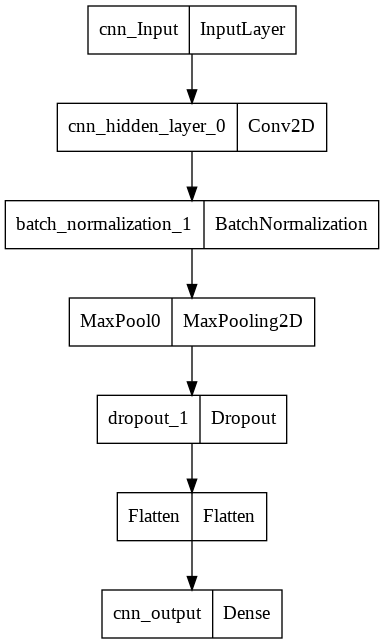

In [ ]:
tf.keras.utils.plot_model(final_CNN_model)

In [ ]:
# with open('fitted_CNN_history_dict.pkl', 'wb') as a_file_pi:
#      pickle.dump(history_model_CNN.history, a_file_pi)

In [ ]:
history_model_CNN = pickle.load(open('fitted_CNN_history_dict.pkl','rb')) # this is history_model.history

####Architecture used for the training of the CNN model
For the selection of the architecture, again BayesianOptimization was employed. 
For the layers used, the option of 1-4 hidden layers was given.<br>
We also choose between LeakyReLu and ELU and tune their alphas.<br>
We give the options of 8,16,32,64 or 128 filters for each convolution layer and the kernel options of 3x3 and 5x5.<br>
We give the possibility of batch normalization and after a max pooling we give the option of a dropout.<br>
During the compiling, Adam again is chosen as the optimizer and his learning rate is tuned.<br>
Loss is set to categorical crossentropy.
For the sake of saving time not all hyperpameters had options for the tuning.

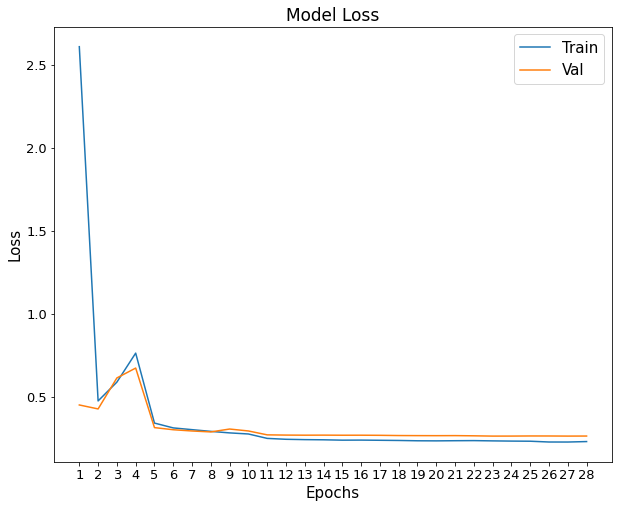

In [ ]:
# Learning Curves Loss-Epochs
plt.figure(figsize=(10,8))
epochs = np.arange(1,len(history_model_CNN['loss'])+1)
plt.plot(epochs,history_model_CNN['loss'])
plt.plot(epochs,history_model_CNN['val_loss'])
plt.title('Model Loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train', 'Val'], fontsize = 15)
plt.xticks(epochs,fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False) # erase grid lines
plt.show()

In this case, of the CNN, for the whole range of 1 to 28 epochs the training and validation losses seem to be close. From the 5th epoch, there is only a slight decrease and the Early Stopping is activated in the at 28th epoch.

In [ ]:
report(cnn_X_train, train_y, "train", final_CNN_model)


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.91      0.89      5402
     Trouser       0.99      0.99      0.99      5364
    Pullover       0.87      0.89      0.88      5410
       Dress       0.93      0.94      0.93      5410
        Coat       0.88      0.88      0.88      5408
      Sandal       0.99      0.99      0.99      5378
       Shirt       0.82      0.76      0.79      5389
     Sneaker       0.96      0.98      0.97      5383
         Bag       0.99      0.99      0.99      5438
  Ankle boot       0.98      0.97      0.98      5418

    accuracy                           0.93     54000
   macro avg       0.93      0.93      0.93     54000
weighted avg       0.93      0.93      0.93     54000



In [ ]:
report(cnn_X_val, val_labels, "val", final_CNN_model)


Precision, recall, F1 scores for each class(val set)
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.85      0.84       598
     Trouser       1.00      0.99      0.99       636
    Pullover       0.84      0.86      0.85       590
       Dress       0.90      0.91      0.90       590
        Coat       0.82      0.84      0.83       592
      Sandal       0.98      0.97      0.98       622
       Shirt       0.78      0.73      0.76       611
     Sneaker       0.95      0.97      0.96       617
         Bag       0.96      0.98      0.97       562
  Ankle boot       0.97      0.96      0.96       582

    accuracy                           0.91      6000
   macro avg       0.90      0.91      0.90      6000
weighted avg       0.90      0.91      0.90      6000



In [ ]:
report(cnn_X_test, int_test_labels, "test", final_CNN_model)


Precision, recall, F1 scores for each class(test set)
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.88      0.86      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.82      0.86      0.84      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.85      0.84      0.85      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.75      0.69      0.72      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
final_CNN_model.evaluate(cnn_X_test, cnn_Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2726 - accuracy: 0.9055


[0.2725895643234253, 0.9054999947547913]

The loss and accuracy of the CNN are 0.2726 and 90.55% respectively. The rest of the metrics-statistics can be seen above.

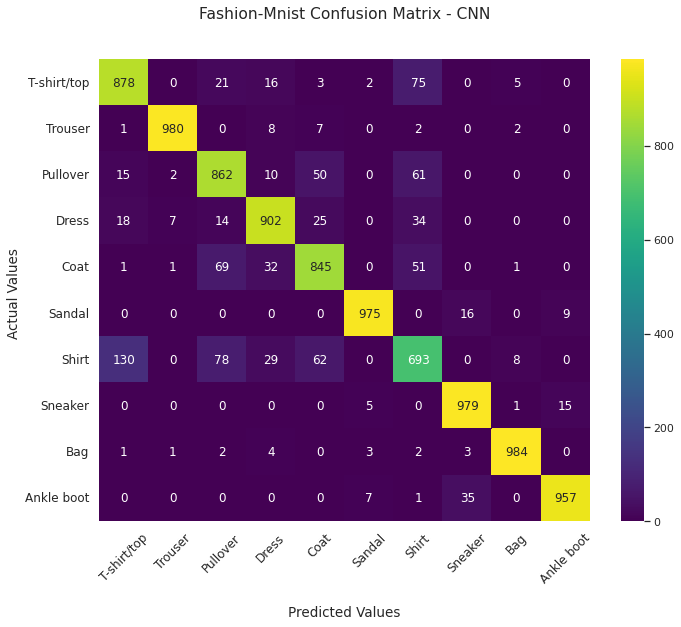

In [ ]:
conf_mat(int_test_labels, cnn_X_test, final_CNN_model, label_names, 'CNN')

As indicated in the confusion matrix and the metrics of the classification report, the classes hardest to predict correctly are the same as in the case of the MLP model, but in the CNN T-shirt/top, Pullover and Coat have a higher accuracy than the MLP, but class Shirt has a lower accuracy compared to the MLP (see number 693).<br><br>Of course, the classes of the test are well balanced, as indicated in the classification report.

In [ ]:
clean_up(model=final_CNN_model)

Detecting the wrong predictions from our best performing model

In [ ]:
model_prediction = final_CNN_model.predict(cnn_X_test)
y_preds = np.zeros((model_prediction.shape[0], 1))
for i in range(model_prediction.shape[0]):
    max_index = np.argmax(model_prediction[i], axis=0)
    y_preds[i] = max_index

In [ ]:
y_bad_pred = [] # indices of the wrong predictions for shirts of the CNN model

for i in range(len(int_test_labels)):

  # searching for misclassifications specificaly in shirts which is the worst performing category
  if int_test_labels[i]== 6 and (y_preds[i][0]!=int_test_labels[i]):
    y_bad_pred.append(i)

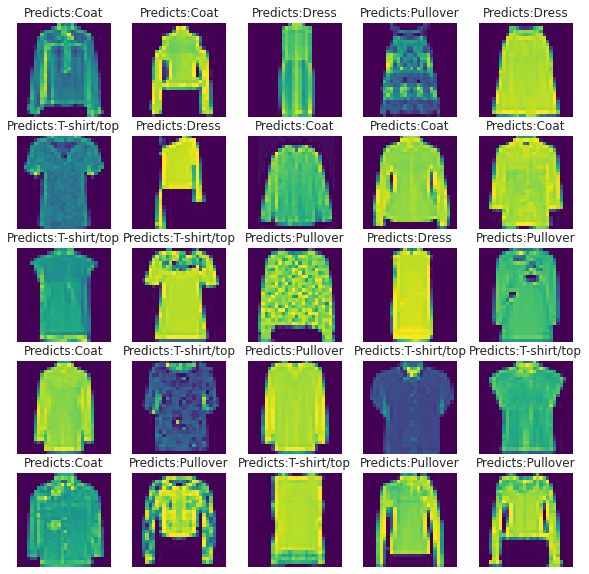

In [ ]:
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    plt.viridis()
    img = np.random.randint(0,len(y_bad_pred)-1)    # choose a random misclassified shirts
    fig.add_subplot(rows, columns, i)
    index = y_bad_pred[img]
    plt.imshow(test_images[index])
    plt.axis('off')
    plt.title("Predicts:" + label_names[int(y_preds[index])])
plt.show()

The images above are all Shirts misclassified to the class that their titles indicate. It is clear the resolution of the images is pretty low and it is no wonder that some of them are even hard for the human eye to classify correctly (confusion even for the human eye).<br>It is interesting to examine the misclassifed images even further.<br><br> In the following barplot, it can be inferred that the misclassified images of Shirts as T-shirt/top are almost double to the rest of the classes individually.

In [ ]:
barplot_dict= {}
for i in y_bad_pred:
  if y_preds[i][0] not in barplot_dict:
    barplot_dict[y_preds[i][0]] = 1
  else:
    barplot_dict[y_preds[i][0]] += 1

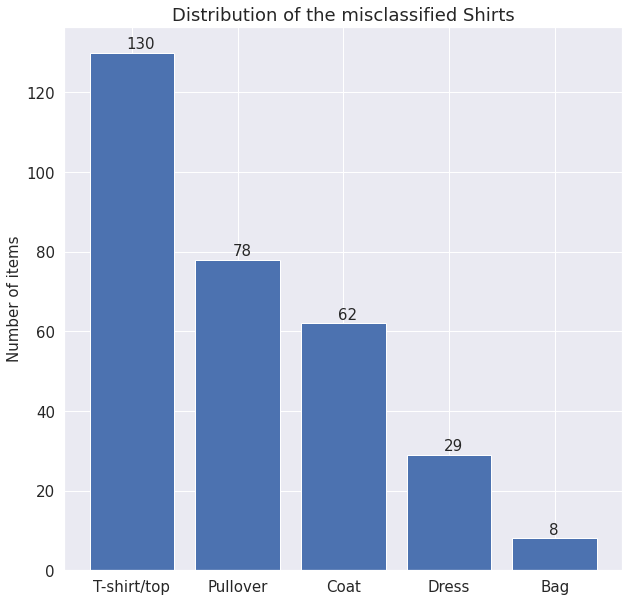

In [ ]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(barplot_dict)), list(barplot_dict.values()), align='center')
plt.yticks(size=15)
plt.ylabel("Number of items", size=15)
plt.title("Distribution of the misclassified Shirts", size=18)
plt.xticks(range(len(barplot_dict)), ["T-shirt/top","Pullover","Coat","Dress","Bag"],size=15)
for index, value in enumerate(barplot_dict.values()):
    plt.text(index-0.05,value+1, str(value),size=15)

plt.show();

###Ideas to get better results:

1) In order to improve our results, augmentation of data could be implemented, such as rotation, distortion of the images and masking of their pixels.<br><br>
2) More Classification models can be applied (NNs, Classifiers) in order to use them in the end in a voting ensemble.<br><br>
3) A pre-trained model can be used, such as AlexNet. An implementation of this idea can be seen in
https://towardsdatascience.com/transfer-learning-using-pre-trained-alexnet-model-and-fashion-mnist-43898c2966fb
<br><br>
4) Since the worst predicted class is Shirt, we can fix a certain threshold of the probability for class Shirt that is output from the softmax and in the cases in which this threshold is reached, the prediction shall indicate Shirt, no matter the probabilities of the rest of the classes. This can be implemented by finding the Q1 Quantile of the distribution of the probabilities output by softmax for class Shirt and setting it as a starting threshold. Then we would rerun the models till they indicate an improvement, while at the same time weghing the threshold by decreasing it or increasing it. However, this would definitely affect the predictions of rest of the classes, so it is not a solution that would certainly give better results. 